<a href="https://colab.research.google.com/github/sivask01/CMPE-255-01/blob/main/255_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Loading**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images from CMFD (Correctly Masked Face Dataset):


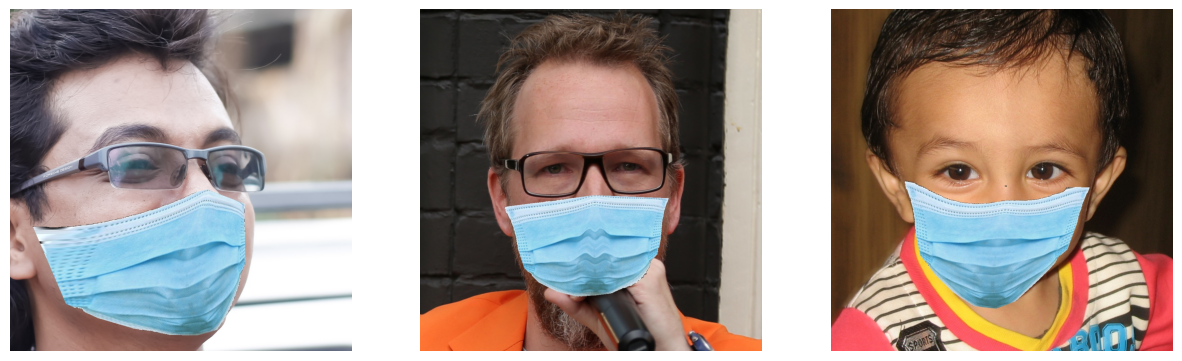

Images from IMFD (Incorrectly Masked Face Dataset):


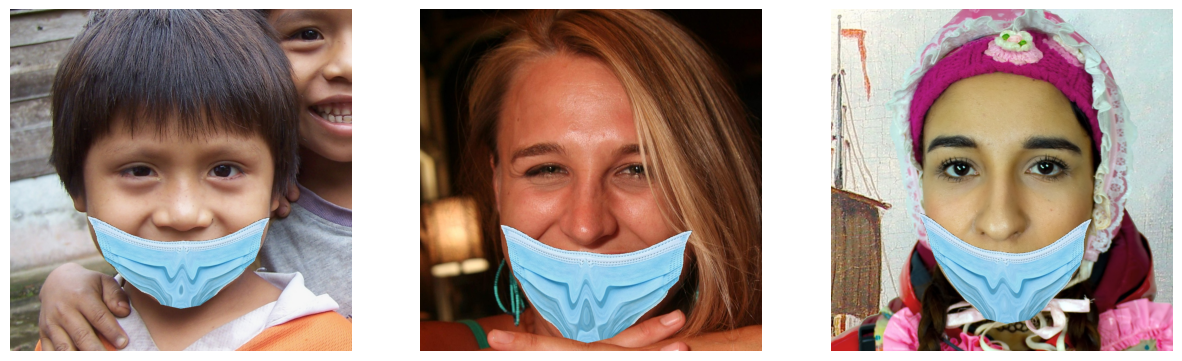

Images from No Mask:


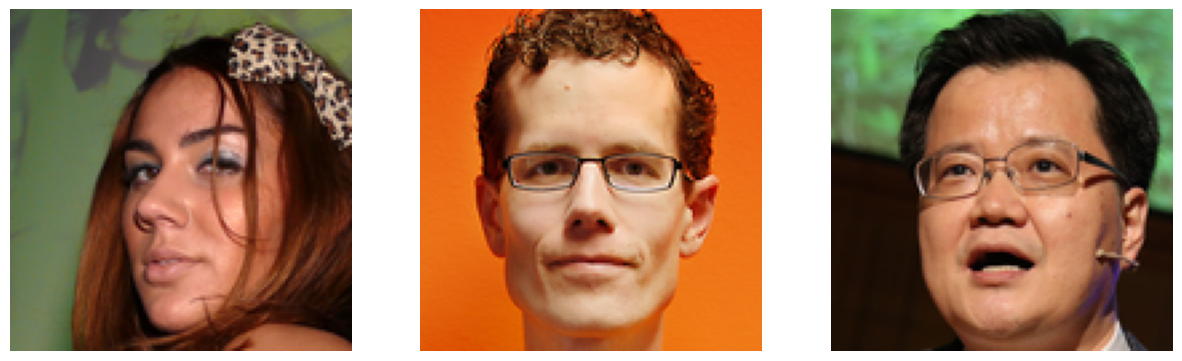

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Path to your dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/Classes/'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display images
def display_images(folder_path, num_images=3):
    image_files = os.listdir(folder_path)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Displaying images from each category
print("Images from CMFD (Correctly Masked Face Dataset):")
display_images(f"{dataset_path}/CMFD")

print("Images from IMFD (Incorrectly Masked Face Dataset):")
display_images(f"{dataset_path}/IMFD")

print("Images from No Mask:")
display_images(f"{dataset_path}/NO_MASK")

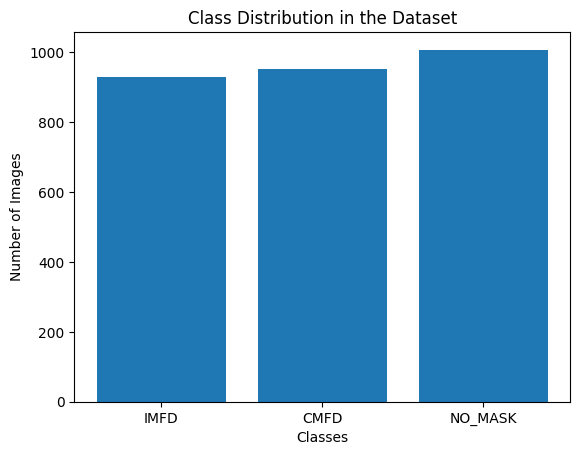

In [ ]:
# Count images in each class
class_distribution = {folder: len(os.listdir(os.path.join(dataset_path, folder)))
                      for folder in os.listdir(dataset_path)}

# Plotting the class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()

#**Data Preprocessing**

In [ ]:
import tensorflow as tf

image_size = (64, 64)

train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    shuffle=False,
    batch_size=1000,
    image_size=image_size
)

Found 2887 files belonging to 3 classes.


#**Build & Train the model**

In [ ]:
import tensorflow_decision_forests as tfdf

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
  tfdf.keras.RandomForestModel(verbose=2)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model.
model.fit(train)


Use 2 thread(s) for training
Use /tmp/tmp0amshcau as temporary training directory


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 18s 5s/step - loss: nan - accuracy: 0.3298


#**Test the Model**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return np.argmax(prediction, axis=1)

test_folder_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/Test/'
test_images = [os.path.join(test_folder_path, file) for file in os.listdir(test_folder_path) if file.endswith('.jpg')]

for image_path in test_images:
    predicted_index = predict_image(image_path, model)[0]
    class_prediction = ['CMFD', 'IMFD', 'No Mask'][predicted_index]
    print(f"Image: {os.path.basename(image_path)}, Prediction: {class_prediction}")

1/1 [==============================] - 0s 79ms/step
Image: test1.jpg, Prediction: CMFD
1/1 [==============================] - 0s 20ms/step
Image: test2.jpg, Prediction: CMFD
1/1 [==============================] - 0s 23ms/step
Image: test3.jpg, Prediction: CMFD
1/1 [==============================] - 0s 22ms/step
Image: test4.jpg, Prediction: CMFD


#**Confusion Matrix**

1/1 [==============================] - 0s 20ms/step


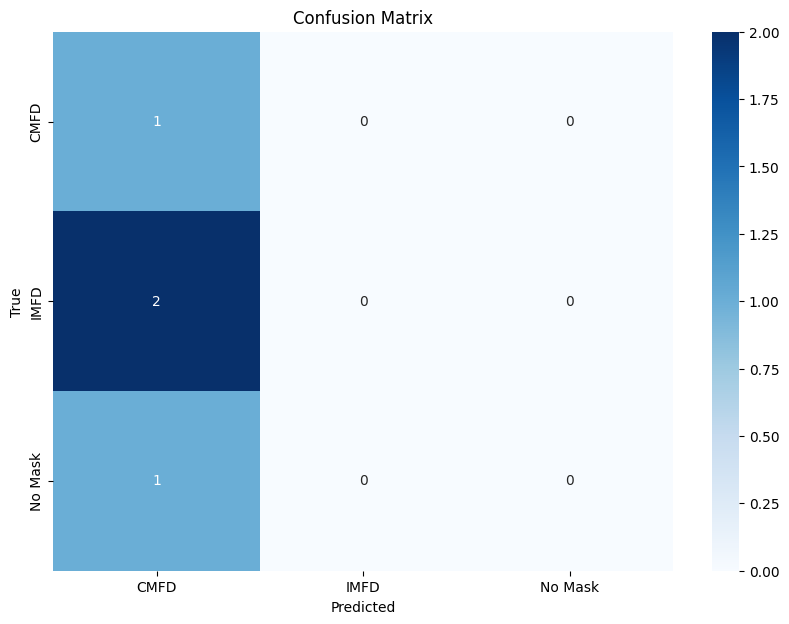

              precision    recall  f1-score   support

        CMFD       0.25      1.00      0.40         1
        IMFD       0.00      0.00      0.00         2
     No Mask       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.08      0.33      0.13         4
weighted avg       0.06      0.25      0.10         4



In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return np.expand_dims(img_array, axis=0)

# Path to the test images folder
test_folder_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/Test'
test_image_paths = [os.path.join(test_folder_path, f) for f in os.listdir(test_folder_path) if f.endswith('.jpg')]

# Predicting each image
predictions = []
for img_path in test_image_paths:
    processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction, axis=1)
    predictions.extend(predicted_class)

# True labels (you need to provide this based on your knowledge of the data)
true_labels = [0,2,1,1]  # Replace with the actual labels, like [0, 0, 1, 2, ...]

# Generating the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['CMFD', 'IMFD', 'No Mask'],
            yticklabels=['CMFD', 'IMFD', 'No Mask'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_labels, predictions, target_names=['CMFD', 'IMFD', 'No Mask'], zero_division=0))